# Screening Task 1 for QOSF Mentorship

Inspired me to propose a work devoted to show, analyze and visualize different distance metrics of quantum states

## Problem statement

The idea of task 1 is to implement the following variational circuit that prepares a 4 qubit state $| \Psi(\theta)\rangle$

<img src="images/circuit1.jpg">

Here, we call as a layer to the combination of an odd block (yellow) and an even block (green). The number of layers denoted by $L$ is an hyperparameter of the variational circuit.

Specifically, each block is defined as follows:

                                             Odd block
<img src="images/odd_block.jpg" style="width:350px;height:150px"/>

                                             Even block
<img src="images/even_block.jpg" style="width:500px;height:150px"/>

Where the double qubits gates are $CZ$ gates and a layer of the variational circuit is composed by 8 parameters denoted by $\theta_{i, n}$ (4 parameters per block).

The idea is to report with a plot, as a function of the number of layers, the minimum distance

$\varepsilon = min_{\theta}\left \| |\Psi(\theta) - \phi \rangle \right \|$

Where $|\phi\rangle$ is a randomly generated vector of 4 qubits, i.e. 16 dimensions, and $\left \| v \rangle \right \| = \sqrt{\langle v| v \rangle} = \sqrt{v^{\dagger}v}$. The right set of parameters $\theta_{i, n}$ can be found via any method of choice.

You can go to the source document where all the screening tasks are explained and discussed <a href="https://docs.google.com/document/d/1Ow3v8Y4rYBdgxXNxKV9ZUAM4bwL6211U6DWCcByZ4A4/edit" target="_blank">here</a>.

## Overview of this work

This work is organized as follows:

1. Generate a proper random quantum state, its probability vector, density matrix and quantum fidelity.


2. Building the variational quantum circuit using `Qiskit`.


3. Optimization of the variational circuit in `Qiskit Aer StatevectorSimulator` backend `COBYLA` optimizer. Minimizing the Euclidean distance of two complex vectors.


4. Optimization of the variational circuit in `Qiskit Aer QasmSimulator` backend `COBYLA` optimizer. Minimizing the diagonal terms of two density matrices or minimizing the probability distribution of the outcomes in a given basis.


5. Building the variation quantum circuit using `Pennylane`.


6. Optimizating Quantum Fidelity in `Pennylane` using `GradientDescentOptimizer` optimizer. Maximizing the quantum fidelity between two quantum states or maximizing the probability of observing the system to be in a target quantum state.


<a href="https://qiskit.org/documentation/tutorials/simulators/1_aer_provider.html" target="_blank">Qiskit Aer Simulators.</a>

### Imports

In [1]:
import pennylane as qml
from pennylane import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qiskit.visualization import plot_histogram, plot_state_city
from qiskit.aqua.components.optimizers import COBYLA
import matplotlib.pyplot as plt

## Define some useful plot functions

In [2]:
def plot_density_matrix(n_layers, params): 
    
    qc = build_variational_circuit(n_layers, params)
    backend = Aer.get_backend('statevector_simulator')
    statevector = execute(qc, backend).result().get_statevector(qc, decimals = 3)

    return plot_state_city(statevector, title=f'State after optimization of a {n_layers} layer variational circuit')
    
def plot_measurements(n_layers, params):
    
    qc = build_variational_circuit(n_layers, params)
    NUM_SHOTS = 10000
    backend = Aer.get_backend("qasm_simulator")
    qc.measure_all()
    result = execute(qc, backend, shots = NUM_SHOTS).result()
    counts = result.get_counts(qc)
    return plot_histogram(counts, title=f'State counts after optimization of {n_layers} layer circuit')

## Generating a proper random quantum state and its probability vector

Explain some things here
$|\psi\rangle \rightarrow |\psi\rangle \langle \psi |$

In [3]:
def norm(complex_vector: np.array) -> float:
    """Returns the norm of a complex vector.
    
    Args:
       complex_vector (np.arrray of shape (dim,)):
           complex vector with an arbitrary dimension.
           
       
    Returns:
        norm (float): norm or magnitude of the complex vector.
            
    """
    
    #define the norm of a complex vector here
    norm = np.sqrt(sum([np.square(np.absolute(complex_vector[i])) for i in range(complex_vector.shape[0])]))
    
    return norm

def random_quantum_state(dim: int, amplitude_type: str = 'complex') -> np.array:
    """Creates a normalized random real or complex vector of a defined
    dimension.
    
    Args:
        dim (int): integer number specifying the dimension
            of the vector that we want to generate.
            
        amplitude_type (str): string indicating if you want to create a
            vector with 'complex' or 'real' number amplitudes.
            
    Returns:
        (np.array): normalized real or complex vector of the given
            dimension.
    """
    #generate an unnormalized complex vector of dimension = dim
    if amplitude_type == 'complex':
        Z = np.random.random(dim) + np.random.random(dim)*1j
    
    #generate an unnormalized real vector of dimension = dim
    elif amplitude_type == 'real':
        Z = np.random.random(dim)
    
    #normalize the complex vector Z
    Z /= norm(Z)
    
    return Z

def get_probabilities(complex_vector: np.array) -> np.array:
    """Get the probabilities associated to a quantum state.
    This is a vector in which each element is the square of
    the magnitude of the respective complex number in that element.
    
    Args:
        complex_vector (np.array):
        
    Retuns:
        (np.array): 
    """
    
    if 1.0 - norm(complex_vector) > 0.001:
        print("Alert! The quantum state apparently is not normalized.")
        
    else:
        return np.square(np.absolute(complex_vector))
    
def density_matrix(target_vector: np.array) -> np.array:
    
    target_vector_reshape = target_vector.reshape((target_vector.shape[0],1))
    density_matrix = target_vector_reshape @ np.transpose(np.conjugate(target_vector_reshape))
    
    return density_matrix

def quantum_fidelity(v1: np.array, v2: np.array) -> float:
    
    v1_reshape = v1.reshape((v1.shape[0], 1))
    v2_reshape = v2.reshape((v2.shape[0], 1))
    
    inner_product = np.transpose(np.conjugate(v1_reshape)) @ v2_reshape
    
    return np.square(np.absolute(inner_product))[0][0]

## Some checks to the functions defined

In [4]:
n_qubits = 1
dim = 2**(n_qubits)
psi = random_quantum_state(dim)
psi

tensor([0.67329962+0.71452896j, 0.06048559+0.18015958j], requires_grad=True)

In [5]:
get_probabilities(psi)

tensor([0.96388402, 0.03611598], requires_grad=True)

In [6]:
quantum_fidelity(psi, psi)

1.0000000000000009

In [7]:
v1 = np.array([1/np.sqrt(2), 1/np.sqrt(2)])
v2 = np.array([1/np.sqrt(2), -1/np.sqrt(2)])
quantum_fidelity(v1, v2)

0.0

## Building the variational quantum circuit in Qiskit

In [8]:
def build_variational_circuit(number_layers: int, params: np.array) -> QuantumCircuit:
    """Build the variational quantum circuit with a defined
    number of layers.
    
    Arguments:
        number_layers (int): number of layers that we want.
        
        params (np.array): np.array of shape (8*number_layers,)
            with the set of angles for the complete variational
            circuit.
            
    Returns:
        (QuantumCircuit): QuantumCircuit object from Qisikit.
            This is our variational quantum circuit.
    """
    
    #number of parameters depending on the number of layers-
    n_parameters = 8*number_layers
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a circuit of {n_parameters} parameters.")
        
    else:
        #create the circuit
        qr = QuantumRegister(4, name="q")
        cr = ClassicalRegister(4, name="c")
        qc = QuantumCircuit(qr, cr)

        #number of parameters per layer
        n_parameters_per_layer = 8
        for i in range(number_layers):
            start = i*n_parameters_per_layer
            end = (i+1)*n_parameters_per_layer 
            layer(qc, params[start:end])
            
        return qc

def layer(qc: QuantumCircuit, params: np.array) -> None:
    """A layer is defined by a combination of an
    odd block and an even block. First we apply the odd 
    block to the Quantum Circuit and then the even block.
    
    Arguments:
        qc (QuantumCircuit): QuantumCircuit object from Qiskit
            in which we are going to apply the two blocks.
        
        params (np.array): np.array of shape (8,) with the angles
            for each block.
    
    Returns:
        (None)
    """
    
    n_parameters = 8
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a layer of {n_parameters} parameters.")
        
    else:
        odd_block(qc, params[:int(n_parameters/2)])
        even_block(qc, params[int(n_parameters/2):])
        qc.barrier()
        
def odd_block(qc: QuantumCircuit, params: np.array) -> None:
    """Apply the proper set of RX to a Quantum Circuit
    defined by the problem statement.
    
    Arguments:
        qc (QuantumCircuit): QuantumCircuit object from Qiskit
            in which we are going to apply the set of gates.
        
        params (np.array): np.array of shape (4,) with the angles
            for each RX gate.
    
    Returns:
        (None)
    """
    
    n_parameters = 4
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a block of {n_parameters} parameters.")
        
    else:
    
        for i in range(n_parameters):
            qc.rx(params[i], i)
        
def even_block(qc: QuantumCircuit, params: np.array) -> None:
    """Apply the proper set of RZ and CZ to a Quantum Circuit
    defined by the problem statement.
    
    Arguments:
        qc (QuantumCircuit): QuantumCircuit object from Qiskit
            in which we are going to apply the set of gates.
        
        params (np.array): np.array of shape (4,) with the angles
            for each RZ gate.
    
    Returns:
        (None)
    """
    
    n_parameters = 4
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a block of {n_parameters} parameters.")
        
    else:
    
        for i in range(n_parameters):
            qc.rz(params[i], i)

        tuples = [(i,j) for i in range(n_parameters) for j in range(n_parameters) if i < j]

        for tup in tuples:
            qc.cz(tup[0], tup[1])

In [9]:
n_parameters_per_layer = 8
n_layers = 2
params = np.random.rand(n_layers*n_parameters_per_layer)*2*np.pi
qc = build_variational_circuit(n_layers, params)

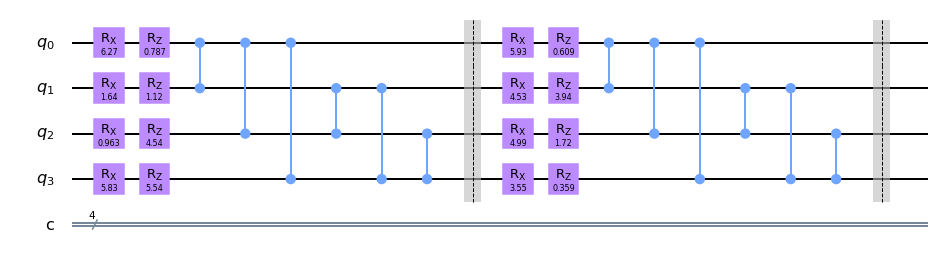

In [10]:
qc.draw(output='mpl')

## Optimization using `Qiskit Aer StatevectorSimulator`

In [11]:
backend = Aer.get_backend('statevector_simulator')

job = execute(qc, backend)

result = job.result()

outputstate = result.get_statevector(qc, decimals=3)
print(outputstate)

[ 0.08131078+0.09103023j -0.02279919+0.00301378j -0.11491359+0.02357193j
 -0.00830779+0.01853366j -0.12158378-0.20311672j -0.04425773-0.00173463j
 -0.02068397+0.04349007j -0.00485405-0.00735391j -0.39458109+0.18261318j
 -0.01256815+0.07773051j -0.58112577-0.09609667j  0.07467357-0.0702324j
 -0.48023458+0.32504651j -0.00213762-0.10795951j -0.0405246 +0.08586565j
  0.00830231+0.01689987j]


In [12]:
def get_outputstate(n_layers, params):
    
    backend = Aer.get_backend('statevector_simulator')
    
    qc = build_variational_circuit(n_layers, params)
    
    job = execute(qc, backend)
    
    result = job.result()

    outputstate = result.get_statevector(qc, decimals=3)
    
    return outputstate

def get_measurement(n_layers, params):
    
    qc = build_variational_circuit(n_layers, params)
    NUM_SHOTS = 10000
    backend = Aer.get_backend("qasm_simulator")
    qc.measure_all()
    result = execute(qc, backend, shots = NUM_SHOTS).result()
    counts = result.get_counts(qc)
    
    return counts
    

def norm_vector_difference(params):

    outputstate = get_outputstate(n_layers, params)
    
    diff = outputstate - target_vector
    
    
    return norm(diff)

def get_probability_distribution(counts):
    output_distr = [v / NUM_SHOTS for v in counts.values()]
    if len(output_distr) == 1:
        output_distr.append(0)
    output_distr = np.asarray(output_distr)
    
    return output_distr

def probability_difference(params):
    # Obtain a quantum circuit instance from the paramters
    qc = build_variational_circuit(n_layers, params)
    # Measure all qubits
    qc.measure_all()
    # Execute the quantum circuit to obtain the probability distribution associated with the current parameters
    result = execute(qc, backend, shots=NUM_SHOTS).result()
    # Obtain the counts for each measured state, and convert those counts into a probability vector
    output_distr = get_probability_distribution(result.get_counts(qc))
    # Calculate the cost as the distance between the output distribution and the target distribution
    cost = sum([np.square(output_distr[i] - target_distr[i]) for i in range(output_distr.shape[0])])
    return cost

## Random target quantum state initialization.

In [13]:
n_qubits = 4
dim = n_qubits**2
target_vector = random_quantum_state(dim)
target_distr = get_probabilities(target_vector)

## Optimization routine with different number of layers

In [14]:
# Initialize the COBYLA optimizer
optimizer = COBYLA(maxiter=1000, tol=0.0001)

# Create the initial parameters (noting that our single qubit variational form has 3 parameters)
cost_list = []
params_list = []
for n_layers in range(1,11):
    n_parameters_per_layer = 8
    params = np.random.rand(n_layers*n_parameters_per_layer)*2*np.pi
    ret = optimizer.optimize(num_vars=n_layers*n_parameters_per_layer, objective_function=norm_vector_difference, 
                             initial_point=params)

    # Obtain the output distribution using the final parameters
    qc = build_variational_circuit(n_layers, ret[0])
    final_vector = execute(qc, backend).result().get_statevector(qc, decimals = 3)
    
    #save cost function values
    cost_list.append(ret[1])
    params_list.append(ret[0])
    
    if n_layers in range(1,11,3):
        print("Number of layers:", n_layers)
        print("Target Vector:", target_vector)
        print("Obtained Vector:", final_vector)
        print("Norm difference:", ret[1])
        print("Parameters Found:", ret[0])
        print('')

Number of layers: 1
Target Vector: [0.34359748+0.05254273j 0.02744883+0.15692767j 0.32877586+0.06408945j
 0.07909072+0.01934138j 0.20247322+0.28476704j 0.12781943+0.16578652j
 0.09542226+0.33884828j 0.19720672+0.03445183j 0.17336098+0.23395169j
 0.00722524+0.19566132j 0.26332441+0.13605792j 0.10883736+0.02248925j
 0.05676905+0.03994771j 0.03932509+0.33963857j 0.00035333+0.01212482j
 0.15698289+0.18767599j]
Obtained Vector: [ 0.47604073-0.j         -0.14254094+0.27772414j  0.01019643+0.16452719j
  0.09903897+0.04331576j  0.06114843+0.40656925j  0.25550388+0.08606483j
  0.139207  -0.02984227j -0.02427267+0.09014962j  0.02609785+0.36103632j
  0.21844457+0.09287956j  0.12422085-0.01675295j -0.02742172+0.0774873j
  0.3049958 -0.06866511j -0.05126542+0.19849622j  0.03026452+0.10394061j
  0.06970149+0.0134665j ]
Norm difference: 0.8543745467966289
Parameters Found: [1.16082505 6.9498972  1.42475332 4.98294547 3.61578119 3.07969766
 2.99231054 6.21102487]

Number of layers: 4
Target Vector: [0

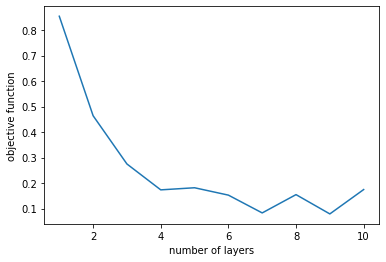

In [15]:
n_layers = range(1,11)
plt.plot(n_layers, cost_list)
plt.xlabel("number of layers")
plt.ylabel("objective function")
plt.show()

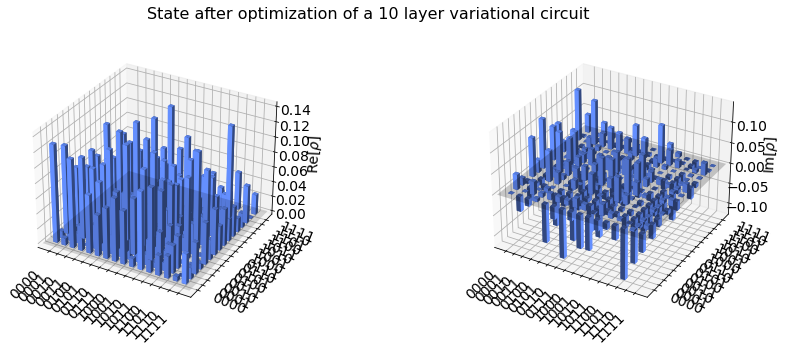

In [16]:
plot_density_matrix(10, params_list[9])

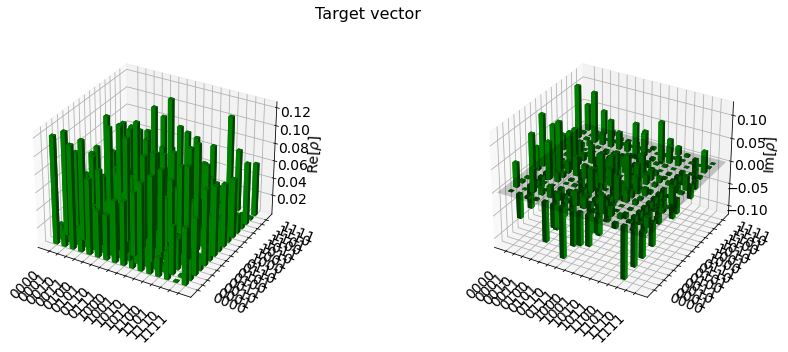

In [17]:
plot_state_city(target_vector, title='Target vector', color = ['green', 'green'])

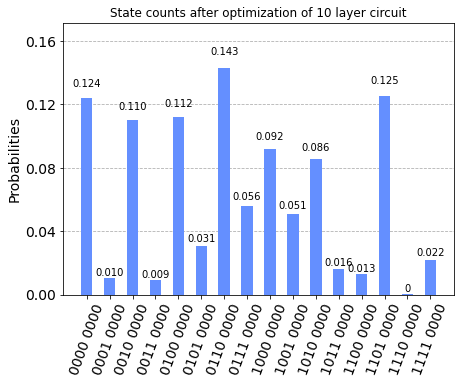

In [18]:
plot_measurements(10, params_list[9])

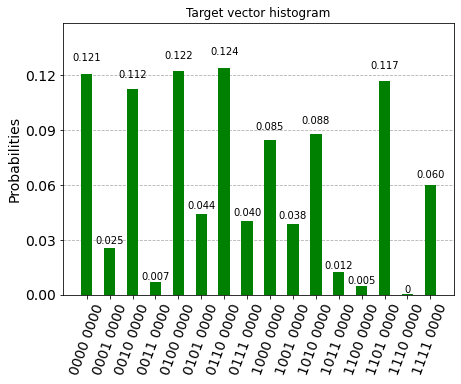

In [19]:
NUM_SHOTS = 10000
counts = get_measurement(10, params_list[9])
counts_target = {list(counts.keys())[i]: target_distr[i]*NUM_SHOTS for i in range(target_distr.shape[0])}
plot_histogram(counts_target, title='Target vector histogram', color = 'green')

In [20]:
n_layers = 10
print(f"Norm of the difference: {norm_vector_difference(params_list[9])}")
output_state = get_outputstate(n_layers, params_list[9])
print(f"Quantum fidelity: {quantum_fidelity(output_state, target_vector)}")

Norm of the difference: 0.17436037164776852
Quantum fidelity: 0.9701637560646748


In [21]:
backend = Aer.get_backend("qasm_simulator")
NUM_SHOTS = 10000

# Initialize the COBYLA optimizer
optimizer = COBYLA(maxiter=1000, tol=0.0001)

# Create the initial parameters (noting that our single qubit variational form has 3 parameters)
n_parameters_per_layer = 8
cost_list = []
params_list = []
for n_layers in range(1,11):
    params = np.random.rand(n_layers*n_parameters_per_layer)*2*np.pi
    ret = optimizer.optimize(num_vars=n_layers*n_parameters_per_layer, objective_function=probability_difference, 
                             initial_point=params)

    # Obtain the output distribution using the final parameters
    qc = build_variational_circuit(n_layers, ret[0])
    qc.measure_all()
    counts = execute(qc, backend, shots=NUM_SHOTS).result().get_counts(qc)
    output_distr = get_probability_distribution(counts)
    
    cost_list.append(ret[1])
    params_list.append(ret[0])
    
    if n_layers in range(1,11,3):
        print("Number of layers:", n_layers)
        print("Target Distribution:", target_distr)
        print("Obtained Distribution:", output_distr)
        print("Output Error (square-error):", ret[1])
        print("Parameters Found:", ret[0])
        print('')

Number of layers: 1
Target Distribution: [0.12081996 0.02537973 0.11220102 0.00662943 0.12208767 0.04382298
 0.12392357 0.04007742 0.08478742 0.03833555 0.0878515  0.01235134
 0.00481854 0.11690082 0.00014714 0.0598659 ]
Obtained Distribution: [0.0979 0.0513 0.1008 0.0467 0.0968 0.0465 0.0906 0.0462 0.0721 0.039
 0.0736 0.0356 0.066  0.0346 0.0673 0.035 ]
Output Error (square-error): 0.021643600434381422
Parameters Found: [7.51155173 4.72264765 4.73578935 1.4237426  2.48047038 4.53369793
 1.26021915 1.0186406 ]

Number of layers: 4
Target Distribution: [0.12081996 0.02537973 0.11220102 0.00662943 0.12208767 0.04382298
 0.12392357 0.04007742 0.08478742 0.03833555 0.0878515  0.01235134
 0.00481854 0.11690082 0.00014714 0.0598659 ]
Obtained Distribution: [0.1178 0.023  0.1287 0.0184 0.1197 0.0363 0.1231 0.0416 0.1031 0.0464
 0.0722 0.0078 0.0091 0.1011 0.0455 0.0062]
Output Error (square-error): 0.0070621000602028245
Parameters Found: [2.96408183 4.35093517 3.51000185 1.6047163  4.5908277

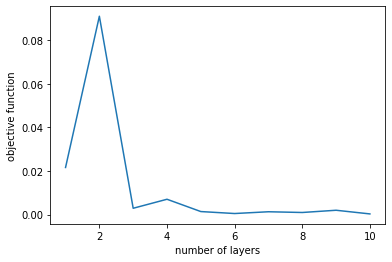

In [22]:
n_layers = range(1,11)
plt.plot(n_layers, cost_list)
plt.xlabel("number of layers")
plt.ylabel("objective function")
plt.show()

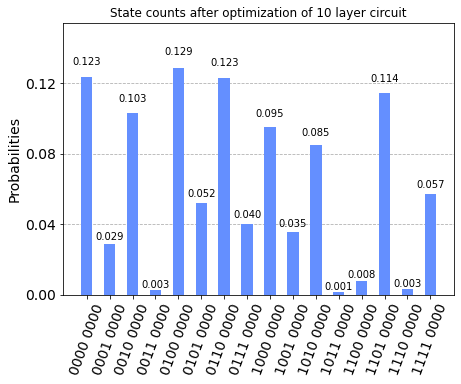

In [23]:
plot_measurements(10, params_list[9])

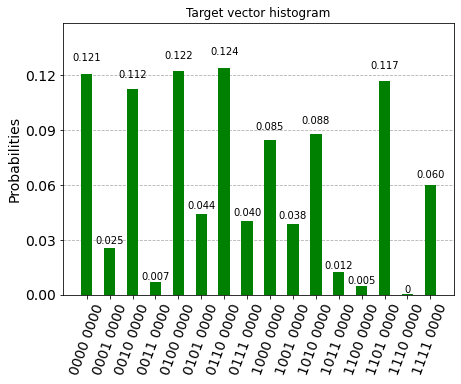

In [24]:
NUM_SHOTS = 10000
counts = get_measurement(10, params_list[9])
counts_target = {list(counts.keys())[i]: target_distr[i]*NUM_SHOTS for i in range(target_distr.shape[0])}
plot_histogram(counts_target, title='Target vector histogram', color = 'green')

In [25]:
n_layers = 10
print(f"Norm of the difference: {norm_vector_difference(params_list[9])}")
output_state = get_outputstate(n_layers, params_list[9])
print(f"Quantum fidelity: {quantum_fidelity(output_state, target_vector)}")

Norm of the difference: 1.5142473852992706
Quantum fidelity: 0.042643598169212635


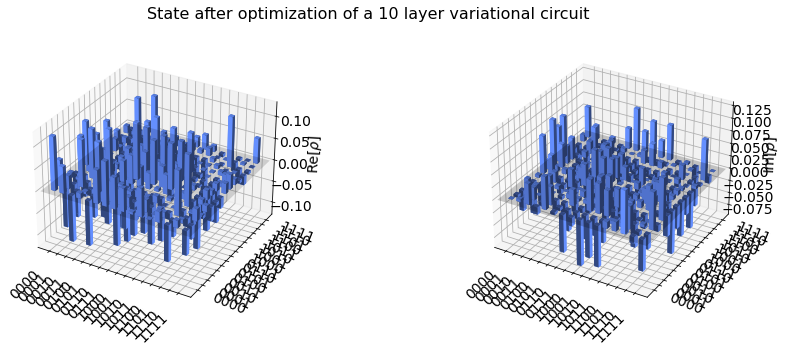

In [26]:
plot_density_matrix(10, params_list[9])

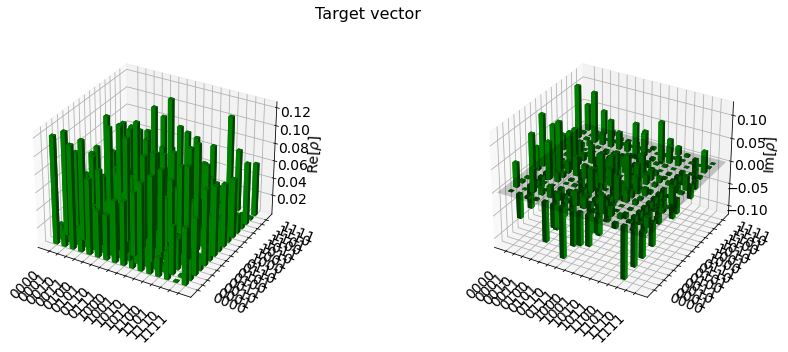

In [27]:
plot_state_city(target_vector, title='Target vector', color = ['green', 'green'])

## Optimize the variational circuit using Pennylane

In [28]:
dev = qml.device('default.qubit', wires = 4)

In [29]:
density_matrix = density_matrix(target_vector)

In [30]:
def layer_pennylane(params: np.array) -> None:
    
    n_parameters = 8
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a layer of {n_parameters} parameters.")
        
    else:
        odd_block_pennylane(params[:int(n_parameters/2)])
        even_block_pennylane(params[int(n_parameters/2):])

def odd_block_pennylane(params: np.array) -> None:
    
    n_parameters = 4
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a block of {n_parameters} parameters.")
        
    else:
    
        for i in range(n_parameters):
            qml.RX(params[i], wires = i)
        

def even_block_pennylane(params: np.array) -> None:
    
    n_parameters = 4
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a block of {n_parameters} parameters.")
        
    else:
    
        for i in range(n_parameters):
            qml.RZ(params[i], wires = i)

        tuples = [(i,j) for i in range(n_parameters) for j in range(n_parameters) if i < j]

        for tup in tuples:
            qml.CZ(wires=[tup[0], tup[1]])

In [31]:
@qml.qnode(dev)
def var_circuit(params):

    #number of parameters per layer
    n_parameters_per_layer = 8
    for i in range(number_layers):
        start = i*n_parameters_per_layer
        end = (i+1)*n_parameters_per_layer 
        layer_pennylane(params[start:end])

    return qml.expval(qml.Hermitian(density_matrix, wires=[0,1,2,3]))

In [32]:
def cost(x):
    
    return (1.0 - var_circuit(x))

In [33]:
n_parameters_per_layer = 8
number_layers = 1
params = np.random.rand(number_layers*n_parameters_per_layer)*2*np.pi

circ = var_circuit(params)
print(norm(dev.state - target_vector))
print(quantum_fidelity(dev.state, target_vector))

1.3067609415367782
0.026460743185094962


In [34]:
cost_list = []
params_list = []
for number_layers in range(1,11):
    init_params = np.random.rand(number_layers*n_parameters_per_layer)*2*np.pi
    opt = qml.GradientDescentOptimizer(stepsize = 0.4)

    steps = 100

    params = init_params
    for i in range(steps):

        params = opt.step(cost, params)

    print(cost(params))
    cost_list.append(cost(params))
    params_list.append(params)

0.5966136590750155
0.21123327298759986
0.1689712572246096
0.008256508749730496
0.005230788743728176
0.0002974221093313689
0.0001355363795614295
5.6922319291441426e-06
2.8238531839530623e-06
2.857093783781295e-08


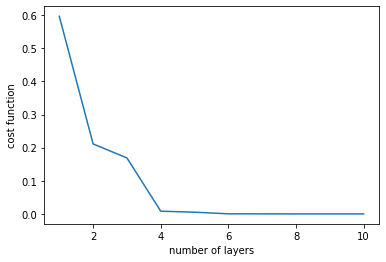

In [35]:
n_layers = range(1,11)
plt.plot(n_layers, cost_list)
plt.xlabel("number of layers")
plt.ylabel("cost function")
plt.show()

In [36]:
circuit = var_circuit(params_list[9])
output_state = dev.state
print(f"Norm of the differece: {norm(output_state - target_vector)}")
print(f"Quantum Fidelity: {quantum_fidelity(output_state, target_vector)}")

Norm of the differece: 1.9554919361958352
Quantum Fidelity: 0.9999999714290617


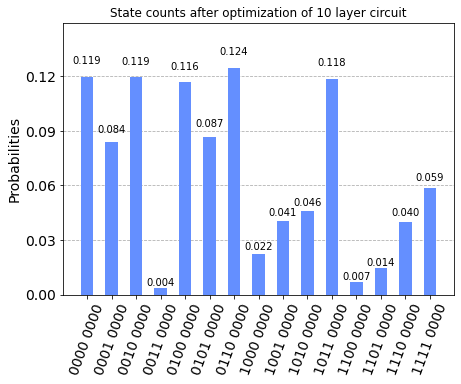

In [37]:
plot_measurements(10, params_list[9])

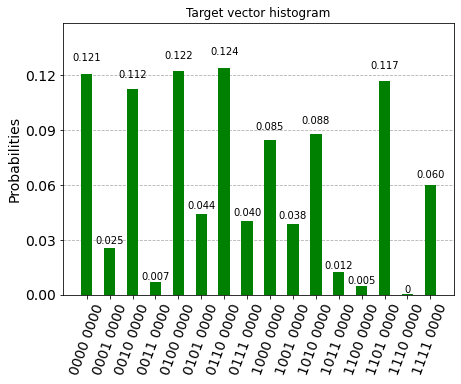

In [38]:
NUM_SHOTS = 10000
counts = get_measurement(10, params_list[9])
counts_target = {list(counts.keys())[i]: target_distr[i]*NUM_SHOTS for i in range(target_distr.shape[0])}
plot_histogram(counts_target, title='Target vector histogram', color = 'green')

## Conclusions

As we can see from this work 

$\mathrm{Re}\left \{ \langle \Psi(\theta) - \phi| \Psi(\theta) - \phi \rangle \right \} = 1$

## References

1. Quantum feedback by discrete quantum non-demolition measurements:
towards on-demand generation of photon-number states